In [31]:
import numpy as np

class NeuralNetwork(object):
    def __init__(self, layers, random_seed):
        self.layers = layers
        self.random_seed = random_seed
        for i, layer in enumerate(self.layers):
            setattr(layer, 'random_seed', self.random_seed+i)
            layer.initialize_weights()

    def forwardpass(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        for layer in self.layers:
            X_next = layer.fprop(X_next)
        prediction = X_next
        return prediction

    def loss(self, prediction, Y):
        """ Calculate error on the given data. """
        loss = 0.5 * (Y - prediction) ** 2
        return -1.0 * (Y - prediction)

    def backpropogate(self, loss):
        """ Calculate an output Y for the given input X. """
        loss_next = loss
        for layer in reversed(self.layers):
            loss_next = layer.bprop(loss_next)
        return loss

class Layer(object):
    def _setup(self, input_shape):
        """ Setup layer with parameters that are unknown at __init__(). """
        pass

    def fprop(self, input):
        """ Calculate layer output for given input (forward propagation). """
        raise NotImplementedError()

    def bprop(self, output_grad):
        """ Calculate input gradient. """
        raise NotImplementedError()

# Break out activations as separate layers? As in Keras?
class Linear(Layer):

    random_seed = None

    def __init__(self, n_in, n_out,
                 activation_function):
        self.n_in = n_in
        self.n_out = n_out
        self.iteration = 0
        self.activation_function = activation_function

    def initialize_weights(self):
        np.random.seed(seed=self.random_seed)
        self.W = np.random.normal(size=(self.n_in, self.n_out))

    def fprop(self, layer_input):
        self.layer_input = layer_input
        self.activation_input = np.dot(layer_input, self.W)
        return self.activation_function(self.activation_input, bprop=False)

    def bprop(self, layer_gradient):
        dOutdActivationInput = self.activation_function(self.activation_input, bprop=True)
        dLayerInputdActivationInput = layer_gradient * dOutdActivationInput
        dActivationOutputdActivationInput = self.layer_input.T
        output_grad = np.dot(dLayerInputdActivationInput, self.W.T)
        weight_update = np.dot(dActivationOutputdActivationInput, dLayerInputdActivationInput)
        W_new = self.W - weight_update
        self.W = W_new
        self.iteration += 1
        return output_grad

def sigmoid(x, bprop=False):
    if bprop:
        s = sigmoid(x)
        return s*(1-s)
    else:
        return 1.0/(1.0+np.exp(-x))

# Not sure how I'm going to do this...
class TwoLayerNetwork(NeuralNetwork):
    '''
    Class for a neural network with only one hidden layer.
    '''
    def __init__(self, layers, random_seed):
        NeuralNetwork.__init__(self, layers, random_seed)

    def return_layer_outputs(self, X):
        """ Calculate an output Y for the given input X. """
        X_next = X
        layer_outputs = []
        for layer in self.layers:
            X_next = layer.fprop(X_next)
            # Collapse across observations
            np.mean(X_next, axis=0)
            layer_outputs.append(X_next)
        return layer_outputs

In [32]:
layer1 = Linear(n_in=10, n_out=5, activation_function=sigmoid)
layer2 = Linear(n_in=5, n_out=1, activation_function=sigmoid)

In [33]:
nn = TwoLayerNetwork(layers=[layer1, layer2], random_seed=823)

In [34]:
nn

In [35]:
X = np.random.randn(10, 10)

In [36]:
len(nn.return_layer_outputs(X))

2

In [37]:
np.mean(nn.return_layer_outputs(X)[0], axis=0)

array([ 0.52956117,  0.40004239,  0.58557413,  0.66468608,  0.52275286])

In [45]:
%matplotlib inline
import datetime
import random
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.dates import DateFormatter

fig=Figure()
ax=fig.add_subplot(111)
x=[]
y=[]
now=datetime.datetime.now()
delta=datetime.timedelta(days=1)
for i in range(10):
    x.append(now)
    now+=delta
    y.append(random.randint(0, 1000))
ax.plot_date(x, y, '-')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
canvas=FigureCanvas(fig)

In [48]:
canvas.print_png('test.png')

In [7]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib

In [45]:
X1, Y1 = make_classification(n_features=3, 
                             n_redundant=0, 
                             n_informative=1,
                             n_clusters_per_class=1)

In [46]:
Y1.reshape(100,1).shape

(100, 1)

In [47]:
x_cols = ['X' + str(x) for x in range(3)]
all_cols = x_cols + ["Y"]
all_cols

['X0', 'X1', 'X2', 'Y']

In [48]:
df = pd.DataFrame(np.concatenate((X1, Y1.reshape(100,1)), axis=1), columns=all_cols)

In [49]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(1,2))
df[x_cols] = mms.fit_transform(df[x_cols])
df.describe()

,X0,X1,X2,Y
count,100.000000,100.000000,100.000000,100.000000
mean,1.511731,1.344116,1.539174,0.500000
std,0.192096,0.293248,0.191122,0.502519
min,1.000000,1.000000,1.000000,0.000000
25%,1.365022,1.099991,1.398832,0.000000
50%,1.504772,1.193656,1.546733,0.500000
75%,1.627565,1.571031,1.669257,1.000000
max,2.000000,2.000000,2.000000,1.000000


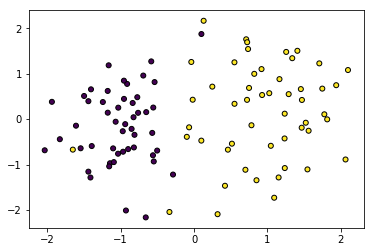

In [60]:
plt.scatter(X1[:, 0], X1[:, 2], marker='o', c=Y1,
            s=25, edgecolor='k');
matplotlib.pyplot.savefig('foo.png')

In [8]:
layers = [[1.248, 1.073], [0.588, 0.63, 0.42], [0.187]]
coords = [{'x': 100.0, 'y': 100.0, 'layer': 0, 'neuron': 0, 'value': 1}, {'x': 100.0, 'y': 380.0, 'layer': 0, 'neuron': 1, 'value': 1}, {'x': 300.0, 'y': 50.0, 'layer': 1, 'neuron': 0, 'value': 1}, {'x': 300.0, 'y': 240.0, 'layer': 1, 'neuron': 1, 'value': 1}, {'x': 300.0, 'y': 430.0, 'layer': 1, 'neuron': 2, 'value': 1}, {'x': 500.0, 'y': 240.0, 'layer': 2, 'neuron': 0, 'value': 1}]

In [11]:
def update_coordinate_values(layers, coords):
    for i in range(len(layers)):
        layer = layers[i]
        for item in coords:
            for j, element in enumerate(layer):
                if item['layer'] == i and item['neuron'] == j:
                    item['value'] = element
    return coords
                
            